# Compare the free energy by direct versus indirect minimisation
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
In this notebook I will apply the schematic from the 'Essentials.ipynb' and 'Minimisation_F.ipynb' files to compute the min_energy, max_entropy and free_energy from the dataset. I compare the direct versus indirect minimisation of free energy, i.e. min[F(p)] versus min[U(p)] - T*max[S(p)].

In [314]:
# Import necessary libraries
import numpy as np
import glob

# Import external background functions
%run background_functions.py

In [2]:
# Import HCP data
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

In [3]:
# Define desired settings
cutoff=0.8 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4

In [51]:
euler_characteristic, clique_complex = compute_euler(matrices[0],cutoff,max_dim)
#clique_complex = [{1,2},{1},{2}]
matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

Compare optimisation parameters for one subject

In [283]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_free_energy = 100
num_iterations_energy = 20000
num_iterations_entropy = 1000
sampling_distributions = ['uniform', 'normal', 'chisquare', 'gamma', 'lognormal', 'pareto', 'custom']
free_energy_probabilities = []
energy_probabilities = []
entropy_probabilities = []
energy_probabilities_test = []

for _ in sampling_distributions:
    initial_probabilities = generate_probability_list(clique_complex, list_size, -0.1, _)
    # Minimum helmholtz free energy
    free_energy_history, current_probabilities_energy = simulated_annealing_free_energy(clique_complex, initial_probabilities, _, -0.1, inverse_connectivity_matrix, num_iterations_free_energy, initial_temperature=1.0, cooling_rate=0.95)
    # Minimum internal energy
    energy_history, current_probabilities_energy = simulated_annealing_energy(clique_complex, initial_probabilities, _ , -0.1, inverse_connectivity_matrix, num_iterations_energy)
    # Maximum shannon entropy
    entropy_history, current_probabilities_entropy = simulated_annealing_entropy(clique_complex, initial_probabilities, _ , -0.1, num_iterations_entropy)

    # Store probabilities type
    free_energy_probabilities.append(free_energy_history)
    energy_probabilities.append(energy_history)
    entropy_probabilities.append(entropy_history)

    energy_probabilities_test.append(current_probabilities_energy)

In [284]:
print(np.sum(energy_probabilities_test[5]))
print(max(energy_probabilities_test[5]))
print(min(energy_probabilities_test[5]))
print(energy_probabilities_test)

0.9999999999999998
0.7293378257406502
6.679423679672042e-06
[array([1.62927618e-03, 2.32605762e-03, 1.62152118e-03, 7.10279974e-03,
       4.43337278e-03, 9.07313786e-03, 9.55009737e-03, 3.64181450e-03,
       8.57634811e-03, 1.93074237e-03, 3.82276400e-03, 4.43312913e-03,
       1.03239559e-02, 1.41525341e-03, 7.28775539e-03, 4.40363165e-03,
       4.01443285e-04, 9.32216657e-03, 2.70174867e-03, 2.48118234e-03,
       7.01178040e-03, 6.20457862e-03, 1.63028708e-03, 4.53477479e-03,
       8.53528756e-03, 4.86568835e-03, 6.72494539e-03, 1.66991350e-03,
       3.32507014e-03, 5.83953804e-03, 4.73585634e-03, 3.76878395e-03,
       5.84716643e-03, 6.16892163e-03, 4.29626947e-03, 9.35499864e-03,
       2.79337851e-03, 1.96114390e-03, 6.16468651e-04, 1.43137585e-03,
       4.66527488e-03, 1.40016878e-04, 9.13713255e-04, 7.73833047e-03,
       7.22853146e-03, 4.44407930e-03, 9.71867032e-03, 1.05472461e-02,
       3.03486654e-03, 3.45181261e-03, 4.67623293e-03, 2.07379874e-03,
       2.4929761

In [285]:
# Generate the theoretical max_entropy and min_energy to compare numerical results
max_entropy_value, min_energy_value = analytical_functionals(matrix, cutoff, max_dim)
max_entropy = [max_entropy_value]*num_iterations_entropy
min_energy = [min_energy_value]*num_iterations_energy

In [286]:
min_energy_value_approximation = energy_function(energy_probabilities_test[5], inverse_connectivity_matrix)
print(min_energy_value_approximation)
print(min_energy_value)
min_energy_approximation = [min_energy_value_approximation]*num_iterations_energy

-0.529401098947982
8.44594594594589e-05


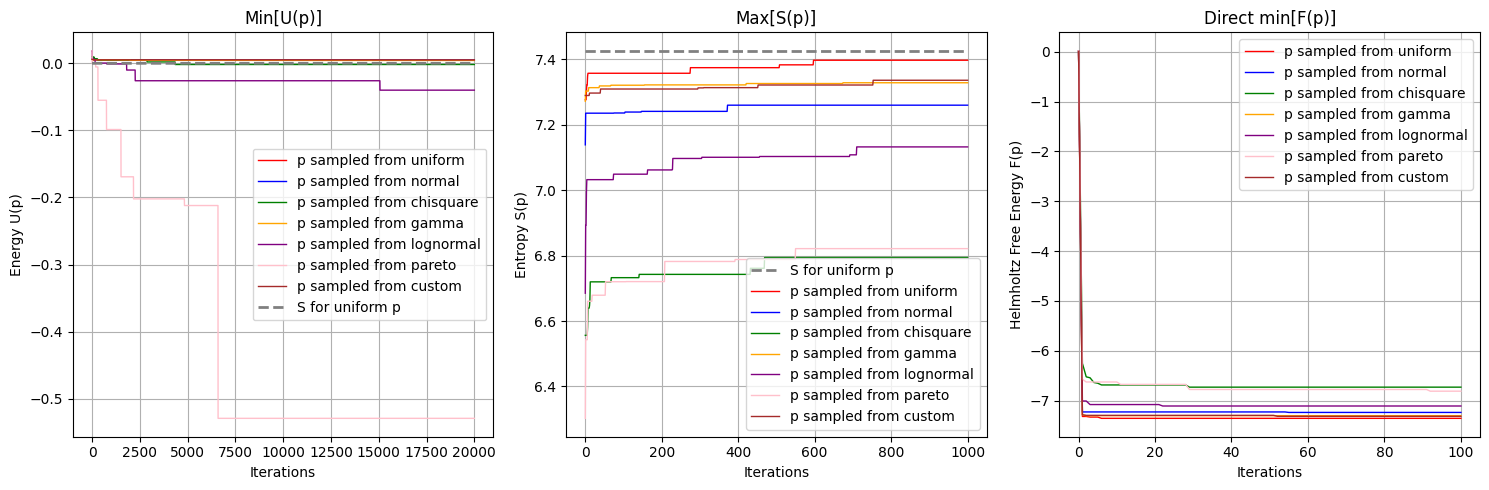

In [287]:
# Plotting the optimisation side by side
plt.figure(figsize=(15, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'yellow']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 3, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.plot(min_energy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
plt.title('Min[U(p)]')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Max[S(p)]')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(len(sampling_distributions)):
    plt.plot(free_energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Direct min[F(p)]')
plt.xlabel('Iterations')
plt.ylabel('Helmholtz Free Energy F(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

For internal energy minimisation pareto seems the best. Test parameters to find the best settings. For the entropy and free energy the uniform distribution are the best, so no additional settings are required. Notice that the free energy minimisation seems to converge much quicker than the other functionals.

In [17]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_energy = 5000
num_iterations_entropy = 5000
energy_probabilities = []
entropy_probabilities = []
pareto_constants = [-0.1, -0.3, -0.6, -0.9]
cooling_rates = [0.99, 0.9, 0.6, 0.3, 0.1]

for pareto_constant in pareto_constants:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , pareto_constant, inverse_connectivity_matrix, num_iterations_energy)
    # Store probabilities type
    energy_probabilities.append(energy_history)

for current_cooling_rate in cooling_rates:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , -0.1, inverse_connectivity_matrix, num_iterations_energy, cooling_rate=current_cooling_rate)
    # Store probabilities type
    entropy_probabilities.append(energy_history)

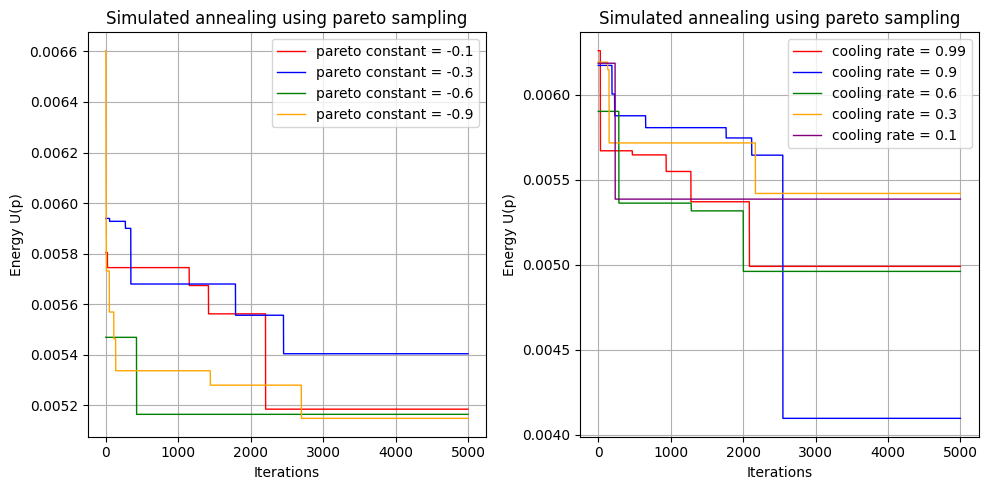

In [18]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(pareto_constants)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'pareto constant = {pareto_constants[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(cooling_rates)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'cooling rate = {cooling_rates[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Generate free energy from direct versus indirect minimisation for all subjects

In [293]:
free_energy_direct = []
free_energy_indirect = []
free_energy_analytical = []

for matrix in matrices:
    # Compute direct free energy
    free_energy_subject_1 = computing_functionals_direct(matrix, cutoff, max_dim)
    free_energy_direct.append(free_energy_subject_1)

    # Compute indirect free energy
    U_min, p_Umin, S_max, p_Smax, free_energy_subject_2 = computing_functionals(matrix,cutoff,max_dim)
    free_energy_indirect.append(free_energy_subject_2)

    # Compute analytical free energy
    max_entropy_value, min_energy_value = analytical_functionals(matrix, cutoff, max_dim)
    free_energy_subject_3 = min_energy_value - max_entropy_value
    free_energy_analytical.append(free_energy_subject_3)

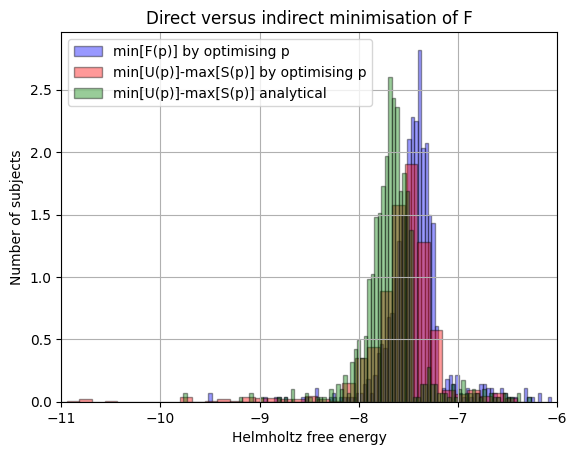

In [16]:
plt.hist(free_energy_direct, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black', label= 'min[F(p)] by optimising p')
plt.hist(free_energy_indirect, bins=100, density=True, alpha=0.4, color='red', edgecolor='black', label = 'min[U(p)]-max[S(p)] by optimising p')
plt.hist(free_energy_analytical, bins=100, density=True, alpha=0.4, color='green', edgecolor='black', label = 'min[U(p)]-max[S(p)] analytical')
plt.xlim(-11, -6)
plt.grid(True)
plt.title('Direct versus indirect minimisation of F')
plt.ylabel('Number of subjects')
plt.xlabel('Helmholtz free energy')
plt.legend()
plt.show()

Why does the direct method converge so much faster (almost instanteneously) compared to the indirect method? And if the direct method is truly close to the minimal free energy, why is there no convergence between distribution types?

In [173]:
clique_complex = [{1,2},{1},{2}]
matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)
print(matrix)
print(inverse_connectivity_matrix)

[[1. 1. 1.]
 [1. 1. 0.]
 [1. 0. 1.]]
[[-1.  1.  1.]
 [ 1. -0. -1.]
 [ 1. -1. -0.]]


In [181]:
print('Energy with p from uniform sampling', energy_function([9.88143162e-01, 6.52177854e-04, 1.12046603e-02],inverse_connectivity_matrix))
print('Energy with p from normal sampling', energy_function([9.97991227e-01, 4.05999969e-04, 1.60277305e-03],inverse_connectivity_matrix))
print('Energy with p from chisquare sampling', energy_function([9.99982503e-01, 4.93987032e-07, 1.70030982e-05],inverse_connectivity_matrix))
print('Energy with p from gamma sampling', energy_function([0.94708286, 0.00748423, 0.04543291],inverse_connectivity_matrix))
print('Energy with p from lognormal sampling', energy_function([0.98322292, 0.011446  , 0.00533109],inverse_connectivity_matrix))
print('Energy with p from pareto sampling', energy_function([9.98311474e-01, 7.87624936e-04, 9.00901418e-04],inverse_connectivity_matrix))
print('Energy with p acc to Knill', energy_function([3/7, 2/7, 2/7],inverse_connectivity_matrix))

print('Entropy with p acc to Knill', shannon_entropy([1/3,1/3,1/3]))

Energy with p from uniform sampling -0.9530090163803451
Energy with p from normal sampling -0.9919783149205901
Energy with p from chisquare sampling -0.9999300127647727
Energy with p from gamma sampling -0.7974121718133572
Energy with p from lognormal sampling -0.9338581108878008
Energy with p from pareto sampling -0.9932558677981969
Energy with p acc to Knill 0.14285714285714285
Entropy with p acc to Knill 0.5283208335737187


explore bifurcation?

In [186]:
F_list = []
B_list = []

for B in np.arange(0, 1, 0.01):
    B_list.append(B)
    F = B*0.14285714285714285 - (1-B)*0.5283208335737187
    F_list.append(F)

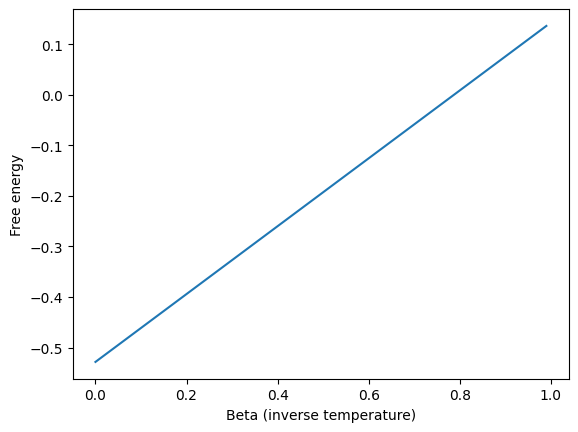

In [190]:
plt.plot(B_list, F_list)
plt.xlabel('Beta (inverse temperature)')
plt.ylabel('Free energy')
plt.show()

Improve by generating higher dimension probabilities from the nodal probabilities.

In [277]:
probabilities_clique_complex = nodes_probabilities(clique_complex)
print(probabilities_clique_complex)

[4.70575109e-03 1.37610765e-03 6.67367606e-04 8.09641402e-03
 1.16969575e-02 3.91899894e-03 4.86014826e-03 1.00247729e-02
 2.46823142e-03 5.15424599e-03 5.51692813e-03 7.85820632e-03
 8.01846798e-03 3.09964713e-03 1.22525695e-03 6.86282482e-03
 1.04142345e-03 4.43671961e-03 1.52561712e-04 1.52010425e-03
 3.02765023e-03 4.35270182e-04 7.02047914e-03 1.18234130e-02
 6.68792410e-04 6.75877076e-03 4.04977655e-03 3.95612506e-03
 2.90589570e-03 9.20515970e-03 5.66898229e-03 6.80659965e-04
 1.86204540e-03 7.32887699e-03 4.49114884e-03 3.36076286e-03
 1.04845453e-03 6.15079171e-04 1.28335250e-03 8.33652609e-03
 2.55077640e-03 1.12754066e-02 4.27230413e-03 3.89084499e-03
 9.30915207e-03 3.32104998e-03 1.12849750e-04 1.17369560e-02
 9.49511985e-03 8.31220223e-03 6.26587340e-03 9.73731304e-03
 7.45302009e-03 2.64303283e-03 4.33099707e-03 4.81316245e-03
 4.02081444e-03 3.51121034e-03 2.02336493e-03 8.13568133e-03
 9.07489812e-04 7.50953479e-03 3.59447766e-03 1.34661619e-03
 5.60611888e-03 8.273751

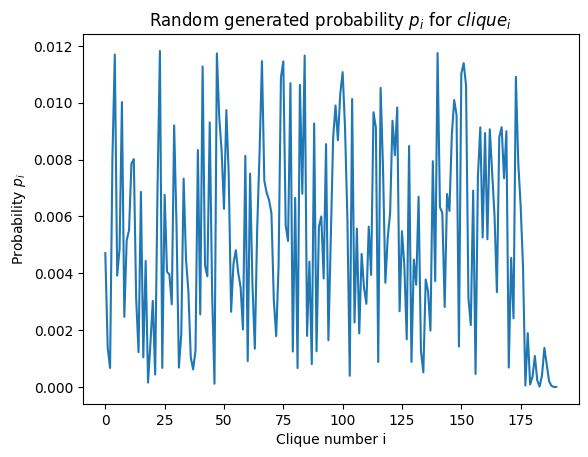

In [278]:
plt.plot(probabilities_clique_complex)
plt.xlabel('Clique number i')
plt.ylabel('Probability $p_i$')
plt.title('Random generated probability $p_i$ for $clique_i$')
plt.show()

In [315]:
# Compute the free energy directly by approximating min_free_energy
def computing_functionals_direct_custom(matrix, cutoff, max_dim):
    clique_complex = build_clique_complex(matrix, cutoff, max_dim)
    print(clique_complex)
    inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)[1]
    initial_probabilities = generate_probability_list(clique_complex, len(inverse_connectivity_matrix), 'custom')
    free_energy_history, f_probabilities = simulated_annealing_free_energy(clique_complex, initial_probabilities, 'custom', -0.1, inverse_connectivity_matrix, 10, initial_temperature=1.0, cooling_rate=0.95)
    return clique_complex, free_energy_history[-1]

In [316]:
free_energy_direct_custom = []

for matrix in matrices[7:8]:
    # Compute direct free energy
    clique_complex, free_energy_subject_4 = computing_functionals_direct_custom(matrix, cutoff, max_dim)
    free_energy_direct_custom.append(free_energy_subject_4)

[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61}, {62}, {63}, {64}, {65}, {66}, {67}, {68}, {69}, {70}, {71}, {72}, {73}, {74}, {75}, {76}, {77}, {78}, {79}, {80}, {81}, {82}, {83}, {84}, {85}, {86}, {87}, {88}, {89}, {90}, {91}, {92}, {93}, {94}, {95}, {96}, {97}, {98}, {99}, {100}, {101}, {102}, {103}, {104}, {105}, {106}, {107}, {108}, {109}, {110}, {111}, {112}, {113}, {114}, {115}, {116}, {117}, {118}, {119}, {120}, {121}, {122}, {123}, {124}, {125}, {126}, {127}, {128}, {129}, {130}, {131}, {132}, {133}, {134}, {135}, {136}, {137}, {138}, {139}, {140}, {141}, {142}, {143}, {144}, {145}, {146}, {147}, {148}, {149}, {150}, {151}, {152}, {153}, {154}, {155}, {156}, {157}, {15

KeyError: '{118, 150}'

Sets in clique complex are not ordered. Are the combinations? -> the itertools.combinations function, when used with a set, does produce combinations in a lexicographically sorted order

In [334]:
# Define a function to obtain a list the simplexes present in the simplicial complex, by counting the complete subgraphs in the connection matrix
def build_clique_complex(correlation_matrix, threshold, max_clique_size):
    n = correlation_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            if abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j)

    # Using nx.enumerate_all_cliques in an interactive manner
    seen_cliques = set()
    nodes_list = [set([i]) for i in range(len(correlation_matrix))] # Add nodes otherwise only > 1-simplexes are included in the clique_complex
    all_cliques = list(nx.enumerate_all_cliques(G)) + nodes_list
    for clique in all_cliques:

        if len(clique) > max_clique_size:
            break
        unique_clique = tuple(sorted(clique))
        seen_cliques.add(unique_clique)

    # Building the clique complex
    clique_complex = [set(clique) for clique in seen_cliques]

    # Sort the list of sets based on the length of cliques and sorted vertices within each clique
    clique_complex = sorted(clique_complex, key=lambda x: (len(x), sorted(x)))

    return clique_complex

In [340]:
correlation_matrix = matrices[0]
threshold = 0.7
max_clique_size = 3

print('___')
print(build_clique_complex(correlation_matrix, threshold, max_clique_size))

___
[{1}, {2}, {4}, {5}, {15}, {16}, {17}, {19}, {20}, {22}, {29}, {30}, {38}, {39}, {42}, {45}, {46}, {47}, {49}, {57}, {60}, {62}, {64}, {66}, {68}, {69}, {70}, {75}, {76}, {78}, {82}, {84}, {85}, {91}, {93}, {94}, {95}, {101}, {110}, {111}, {114}, {119}, {120}, {121}, {124}, {128}, {129}, {130}, {131}, {133}, {134}, {135}, {138}, {144}, {146}, {148}, {149}, {150}, {152}, {154}, {156}, {158}, {162}, {163}, {165}, {168}, {171}, {1, 70}, {16, 2}, {64, 2}, {2, 154}, {19, 4}, {66, 5}, {38, 15}, {130, 15}, {16, 154}, {17, 163}, {19, 95}, {20, 22}, {29, 111}, {30, 47}, {133, 30}, {49, 39}, {42, 62}, {42, 78}, {60, 45}, {76, 45}, {45, 94}, {124, 45}, {156, 45}, {171, 45}, {68, 46}, {148, 46}, {64, 47}, {49, 78}, {49, 121}, {57, 75}, {128, 57}, {57, 135}, {60, 76}, {60, 94}, {156, 60}, {64, 131}, {84, 69}, {129, 69}, {82, 70}, {146, 70}, {149, 70}, {75, 135}, {138, 75}, {76, 94}, {156, 76}, {121, 78}, {165, 78}, {129, 84}, {152, 84}, {168, 84}, {85, 111}, {91, 158}, {93, 119}, {93, 134}, {15